# Предсказание оттока клиентов оператора связи

**Цель работы:**
С помощью модели машинного обучения научиться определять клиентов, собирающихся прекратить сотрудничество с компанией.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Вопросы-заказчику:" data-toc-modified-id="Вопросы-заказчику:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Вопросы заказчику:</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Портрет-уходящего-клиента" data-toc-modified-id="Портрет-уходящего-клиента-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Портрет уходящего клиента</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Отчет-для-заказчика" data-toc-modified-id="Отчет-для-заказчика-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Отчет для заказчика</a></span></li></ul></div>

# Описание данных

У нас в распоряжении находятся четыре датасета:
- contract_new.csv — информация о договоре


- personal_new.csv — персональные данные клиента


- internet_new.csv — информация об интернет-услугах


- phone_new.csv — информация об услугах телефонии


Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020. 


- `BeginDate` - дата начала пользования услугами,


- `EndDate` - дата окончания пользования услугами,


- `Type` - тип договора: ежемесячный, годовой и т.д


- `PaperlessBilling` - факт выставления счёта на электронную почту


- `PaymentMethod` - способ оплаты


- `MonthlyCharges` - ежемесячные траты на услуги


- `TotalCharges` - всего потрачено денег на услуги


- `Dependents` - наличие иждивенцев у клиента


- `Senior Citizen` - наличие пенсионного статуса по возрасту


- `Partner` - наличие супруга(и)


- `Gender` - пол клиента


- `MultipleLines` - наличие возможности ведения параллельных линий во время звонка.


Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);

- Выделенная линия технической поддержки (*TechSupport*);

- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);

- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

# План работы



1) Предобработка данных (изучить датасеты на наличие пропусков, дубликатов и соответствие формата данных содержанию. Недостатки исправить)

2) Исследовательский анализ (посмотреть на распределение целевого признака, создать портрет уходящего клиента, провести анализ данных)

 • Проверка мультиколлинеарности и корреляции признаков с таргетом(в том числе для категориальных признаков)

 • Feature engineering (создать более подходящие признаки для обучения на основе существующих, если надо)

 • Feature selection (отбросить на основе предыдущего анализа неинформативные и дублирующиеся признаки)

3) Исследование моделей

 • Кодирование, масштабирование (подготовить данные к обучению модели с помощью кодирования и разбивки на обучающую и тестовую выборку, а также провести их масштабирование)

 • Выбрать модели для обучения и проверить качество их обучения на данных на основе метрики ROC-AUC, целевой показатель 0,85.

 • Подобрать оптимальные параметры моделей, используя GridSearchCV, отобрать лучшую модель по кросс-валидационной метрике для финального тестирования (также учесть скорость обучения)

4) Тестирование модели (необходимо преодолеть показатель метрики ROC-AUC 0,85)

 • Исследование важности признаков (отбор признаков на основе важности)

 • Калибровка,оценка прибыльности внедрения, пояснение заказчику особенностей нашей модели и интерпретация ее предсказаний. 

5) Выводы на основе проделанной работы.


## Предобработка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

import phik

from phik import resources, report
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

import category_encoders as ce
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

numeric_columns = ['MonthlyCharges', 'TotalCharges', 'Duration_in_days']
categorial_columns = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines',
]

In [2]:
def data_read(file_path):
    data = pd.read_csv(file_path)
    display(data.sample(20, random_state=80523))
    print(data.info())
    print(data.describe())
    print('Количество дубликатов:', sum(data.duplicated()))
    return data

In [3]:
try:
    df_contract = data_read('C:/Users/Vatslav/Downloads/contract_new.csv')
except:
    df_contract = data_read('/datasets/contract_new.csv')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
138,6217-KDYWC,2015-05-01,No,Two year,Yes,Mailed check,19.60,1161.89
4357,7998-ZLXWN,2018-11-01,No,Month-to-month,No,Credit card (automatic),20.45,334.36
1776,5605-XNWEN,2014-02-01,No,Two year,Yes,Bank transfer (automatic),25.00,1836.0
3509,8710-YGLWG,2020-01-01,No,Month-to-month,Yes,Mailed check,44.90,47.15
4020,4334-HOWRP,2014-02-01,No,Two year,Yes,Credit card (automatic),64.95,5144.04
6123,0623-EJQEG,2014-09-01,2018-02-01,One year,No,Electronic check,93.55,4104.04
2433,8314-DPQHL,2019-05-01,No,One year,No,Mailed check,50.80,457.2
2027,3778-FOAQW,2018-02-01,No,One year,No,Mailed check,20.15,483.6
6703,2737-WFVYW,2019-08-01,No,Month-to-month,Yes,Electronic check,45.25,271.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000
Количество дубликатов: 0


In [4]:
df_contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [5]:
df_contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

**Вывод после ознакомления:**

- В датасете с контрактами 8 столбцов, у первых шести формат object, у MonthlyCharges - float. У TotalCharges тоже должен быть формат float, это необходимо исправить. BeginDate и EndDate надо перевести в формат даты.

- есть пустые значения в столбце TotalCharges, например, в 1340-й записи. Дата начала контракта - 2020-02-01, это день выгрузки данных, а следовательно по этому контракту просто нет сведений об оплате. Если таких записей немного, их можно будет удалить.

- "No" в EndDate означает, что пользователь продолжает пользоваться услугами - это целевой признак. 

- Среднее значение ежемесячных платежей примерно 65 долларов(почти равно медианному).

- Дубликатов нет.

- Категориальные признаки(PaymentMethod, Type и PaperlessBilling) надо будет закодировать.



Поменяем тип данных TotalCharges на числовой:

In [6]:
df_contract['TotalCharges'] = pd.to_numeric(
    df_contract['TotalCharges'], errors='coerce')

Посчитаем обнаруженные пропуски:

In [7]:
df_contract['TotalCharges'].isnull().sum()

11

Таких записей всего 11, заменим TotalCharges в них на 0:

In [8]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].fillna(0)
df_contract['TotalCharges'].isnull().sum()

0

Создадим столбец 'Churn' со значениями целевого признака - если в данных указана EndDate, значит клиент ушел(1), если стоит значение "No", контракт действует(0).

In [9]:
df_contract.loc[df_contract['EndDate'] == 'No', 'Churn'] = 0
df_contract.loc[df_contract['EndDate'] != 'No', 'Churn'] = 1

Поменяем формат на дату для BeginDate:

In [10]:
df_contract['BeginDate'] = df_contract['BeginDate'].apply(pd.to_datetime)

Заменим в столбце EndDate значения No на дату выгрузки, чтобы не было утечки данных:

In [11]:
df_contract.EndDate = df_contract.EndDate.replace('No', '2020-02-01')

Меняем формат на дату:

In [12]:
df_contract['EndDate'] = df_contract['EndDate'].apply(pd.to_datetime)

Создадим новый столбец 'Duration_in_days', который будет хранить количество дней, которые клиент был с компанией:

In [13]:
df_contract['Duration_in_days'] = (
    df_contract['EndDate'] - df_contract['BeginDate']).dt.days

In [14]:
df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Duration_in_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0.0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0.0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0.0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0.0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0.0,153
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,0.0,337
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0.0,671
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,0.0,306
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,0.0,945
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1.0,882


In [15]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   float64       
 9   Duration_in_days  7043 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 550.4+ KB


Все исправления сделаны. Изучим файл с персональными данными.

In [16]:
try:
    df_personal = data_read('C:/Users/Vatslav/Downloads/personal_new.csv')
except:
    df_personal = data_read('/datasets/personal_new.csv')

,customerID,gender,SeniorCitizen,Partner,Dependents
1340,1371-DWPAZ,Female,0,Yes,Yes
138,6217-KDYWC,Male,0,No,Yes
4357,7998-ZLXWN,Female,0,Yes,No
1776,5605-XNWEN,Male,1,Yes,No
3509,8710-YGLWG,Male,0,No,No
4020,4334-HOWRP,Male,1,Yes,No
6123,0623-EJQEG,Male,0,No,No
2433,8314-DPQHL,Male,0,No,No
2027,3778-FOAQW,Female,0,Yes,No
6703,2737-WFVYW,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Количество дубликатов: 0


**Вывод после ознакомления:**
У нас 5 столбцов, 7043 записи, дубликатов нет. Исправления не требуются.

In [17]:
try:
    df_internet = data_read('C:/Users/Vatslav/Downloads/internet_new.csv')
except:
    df_internet = data_read('/datasets/internet_new.csv')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3489,3018-TFTSU,Fiber optic,Yes,No,Yes,No,No,No
4699,2887-JPYLU,DSL,No,No,No,No,No,No
2852,9738-QLWTP,Fiber optic,No,No,Yes,Yes,No,No
924,5868-CZJDR,DSL,No,Yes,No,No,No,No
3718,1043-UXOVO,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
3932,4713-LZDRV,Fiber optic,No,No,No,No,No,Yes
5174,4662-EKDPQ,DSL,No,No,No,No,No,Yes
3036,9470-RTWDV,DSL,No,No,Yes,Yes,Yes,Yes
2848,0512-FLFDW,Fiber optic,No,No,Yes,No,Yes,Yes
1094,8999-YPYBV,DSL,Yes,Yes,Yes,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV Streamin

**Вывод после ознакомления:**
У нас 8 столбцов, 5517 записей. Судя по всему, интернетом пользуются не все клиенты, так как количество записей на 1,5 тысячи меньше.

In [18]:
try:
    df_phone = data_read('C:/Users/Vatslav/Downloads/phone_new.csv')
except:
    df_phone = data_read('/datasets/phone_new.csv')

,customerID,MultipleLines
2294,5829-NVSQN,No
3559,1093-YSWCA,No
2616,7517-LDMPS,No
3882,8815-LMFLX,Yes
2062,9537-VHDTA,No
4976,7794-JASDG,No
4610,8779-YIQQA,No
4208,1202-KKGFU,No
2763,7120-RFMVS,Yes
216,9058-HRZSV,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390
Количество дубликатов: 0


**Вывод после ознакомления:**
Телефоном тоже пользуются не все клиенты. Исправления в данных не требуются, дубликатов нет.

Объединим все данные в один датафрейм:

In [19]:
churn_df = df_contract \
    .merge(df_personal, how='left', on=['customerID']) \
    .merge(df_internet, how='left', on=['customerID']) \
    .merge(df_phone, how='left', on=['customerID'])

Проверим уникальность ID клиентов:

In [20]:
churn_df['customerID'].is_unique

True

Установим ID В качестве индекса:

In [21]:
churn_df = churn_df.set_index('customerID')

In [22]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Churn             7043 non-null   float64       
 8   Duration_in_days  7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

Пропуски в InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies и MultipleLines скорее всего означают, что услуги не подключены. Заменим пропуски на "No"

In [23]:
for column in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    churn_df[column] = churn_df[column].fillna('No')

In [24]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Churn             7043 non-null   float64       
 8   Duration_in_days  7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity

Теперь все готово к анализу данных.

## Вопросы заказчику:

Вопросов нет.

## Анализ данных

Посмотрим, какой процент клиентов уходит от компании:

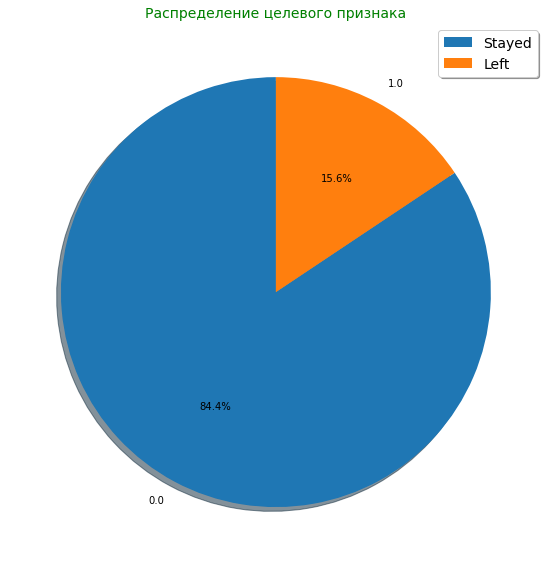

In [25]:
churn_df.Churn.value_counts().plot(kind='pie', autopct='%1.1f%%',
                                   shadow=True, figsize=(12, 8), startangle=90)
plt.legend(['Stayed', 'Left'], fontsize=14, shadow=True,
           facecolor='w', loc='upper right')
plt.title('Распределение целевого признака', color='g', fontsize=14)
plt.tight_layout();
plt.axis('off');

**Вывод:** 15,6% клиентов покинули компанию.

Изучим распределение категориальных признаков:

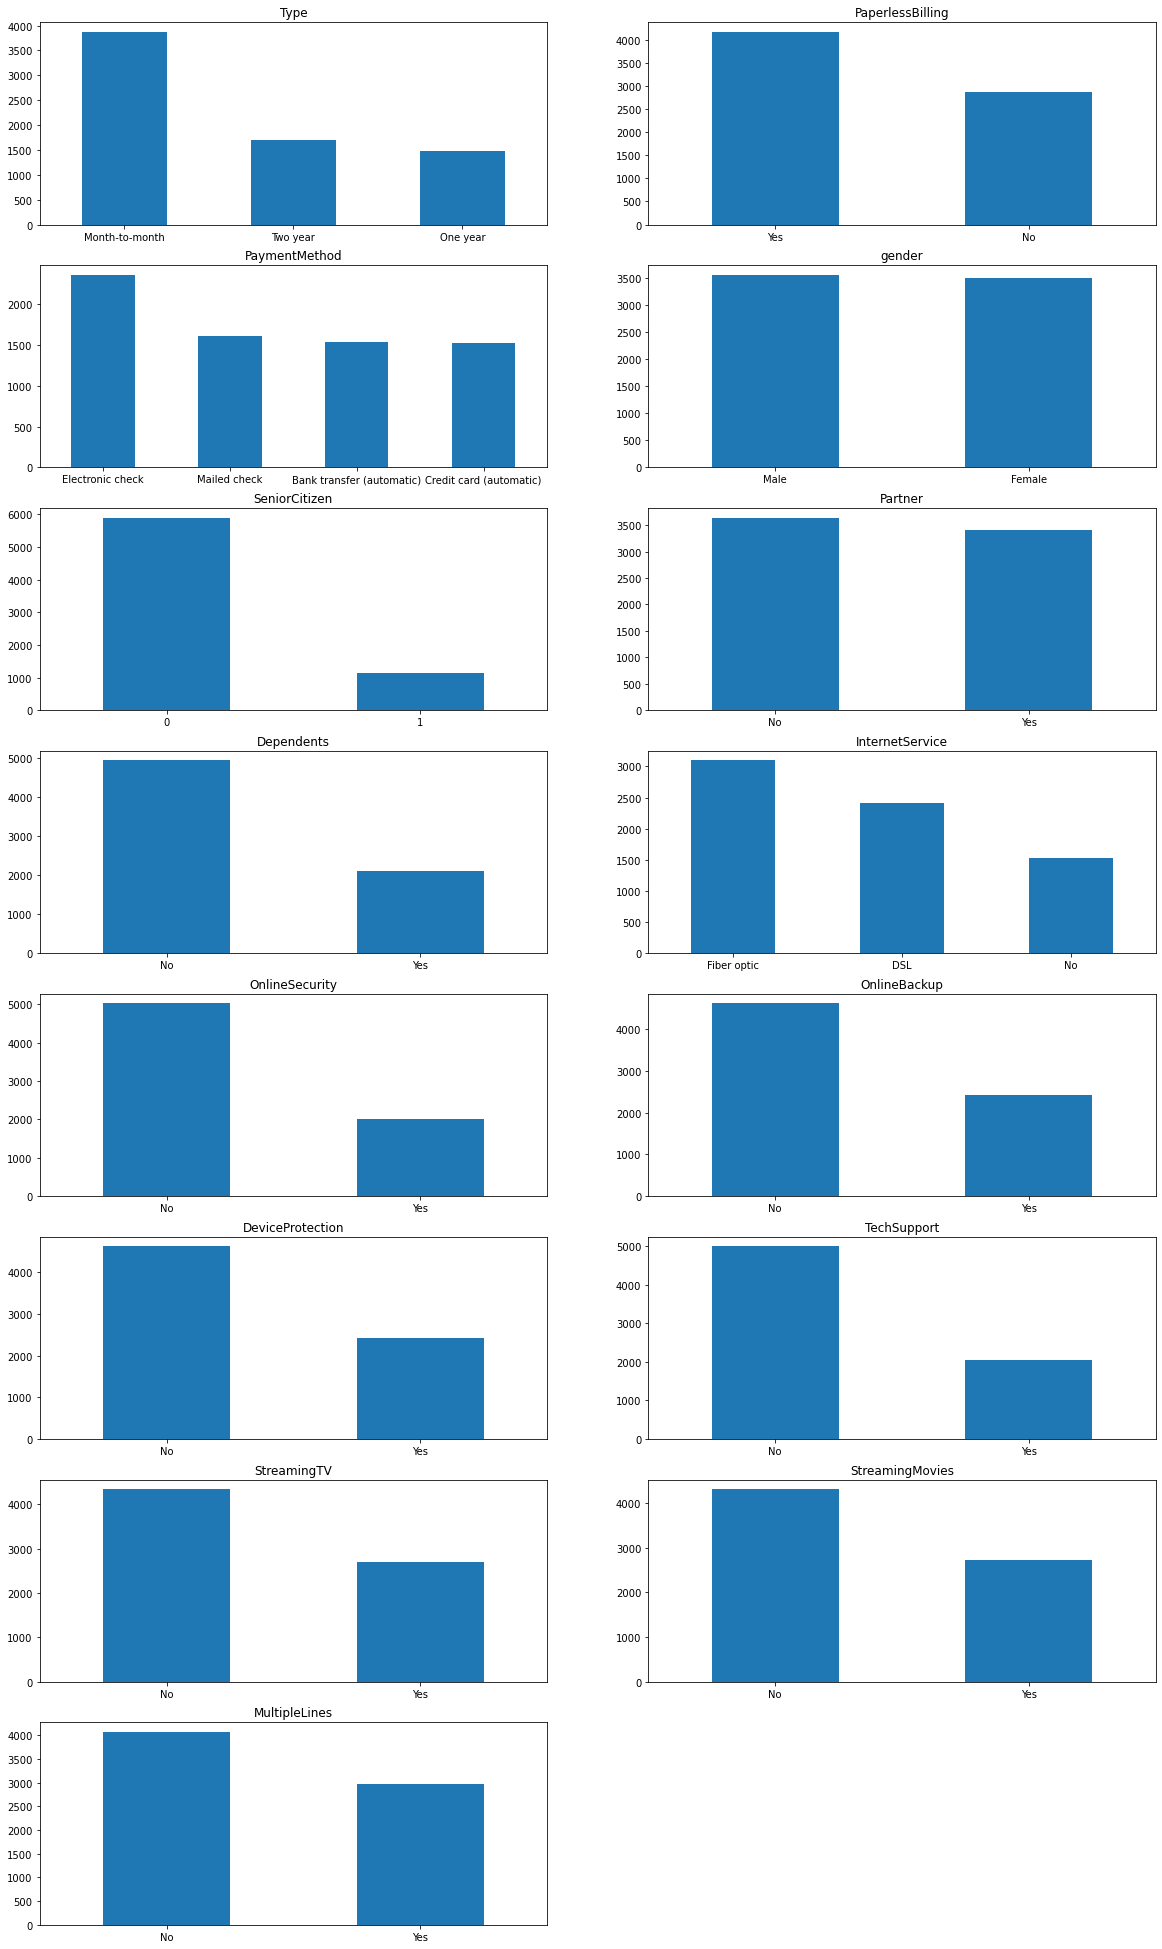

In [26]:
cols = 2
rows = int(np.ceil(len(categorial_columns) / cols))

plt.figure(figsize=(20, 35))

for idx, column in enumerate(categorial_columns):
    ax = plt.subplot(rows, cols, idx + 1)

    churn_df[column].value_counts().plot(
        kind='bar',
        title=column,
        ax=ax,
        rot=0,
    )

plt.show()

**Выводы:**

- Самый популярный способ оплаты - помесячный.

- Большинство клиентов подключены к интернету через оптоволокно.

- Чаще всего люди получают электронный чек и оплачивают его электронными средствами.

- Дополнительные услуги(техподдержка, стриминг, защита) не требуются большинству пользователей.

Изучим теперь количественные признаки:

In [27]:
def plot_numerical(df):
    cols = 3
    rows = 2

    plt.figure(figsize=(15, 10))

    idx = 0
    for column in numeric_columns:
        idx += 1

        plt.subplot(rows, cols, idx)
        plt.hist(df[column])
        plt.title(column)

    for column in numeric_columns:
        idx += 1

        plt.subplot(rows, cols, idx)
        plt.boxplot(df[column])
        plt.title(column)

    plt.show()

    display(df[numeric_columns].describe())

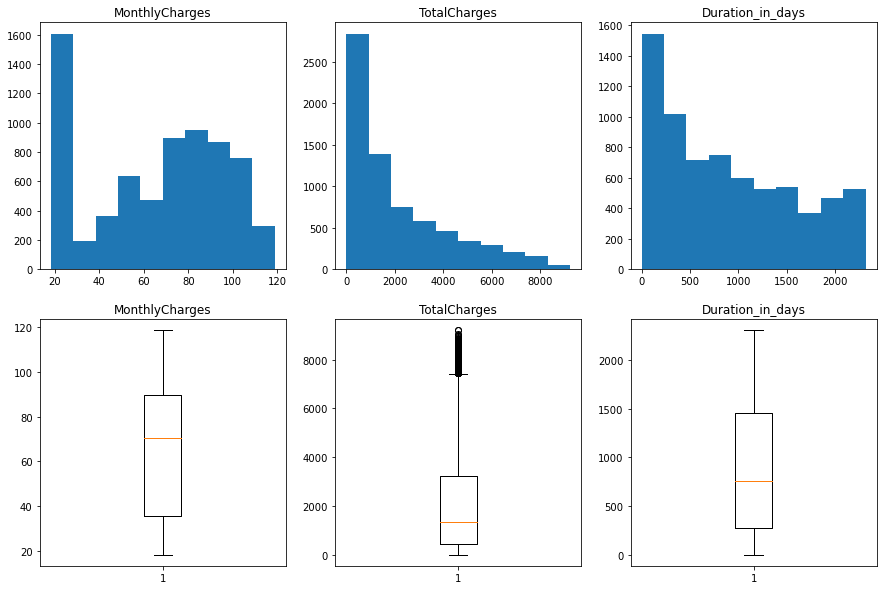

,MonthlyCharges,TotalCharges,Duration_in_days
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,898.555729
std,30.090047,2112.742814,683.130510
min,18.250000,0.000000,0.000000
25%,35.500000,436.750000,276.000000
50%,70.350000,1343.350000,761.000000
75%,89.850000,3236.690000,1461.000000
max,118.750000,9221.380000,2314.000000


In [28]:
plot_numerical(churn_df)

**Выводы:**

- В столбце MonthlyCharges есть два пика в районе 20-25(минимальный тариф) и 70-90. В столбце TotalCharges четко выраженный нисходящий тренд. На основе этих двух фактов можно предположить, что чем больше платит клиент в месяц, тем выше у него шанс покинуть компанию.

- В столбце Duration_in_days пик в районе нуля - это новые пользователи. дальше плюс-минус все ровно.


Проверим как связаны количественные признаки с нашим таргетом:

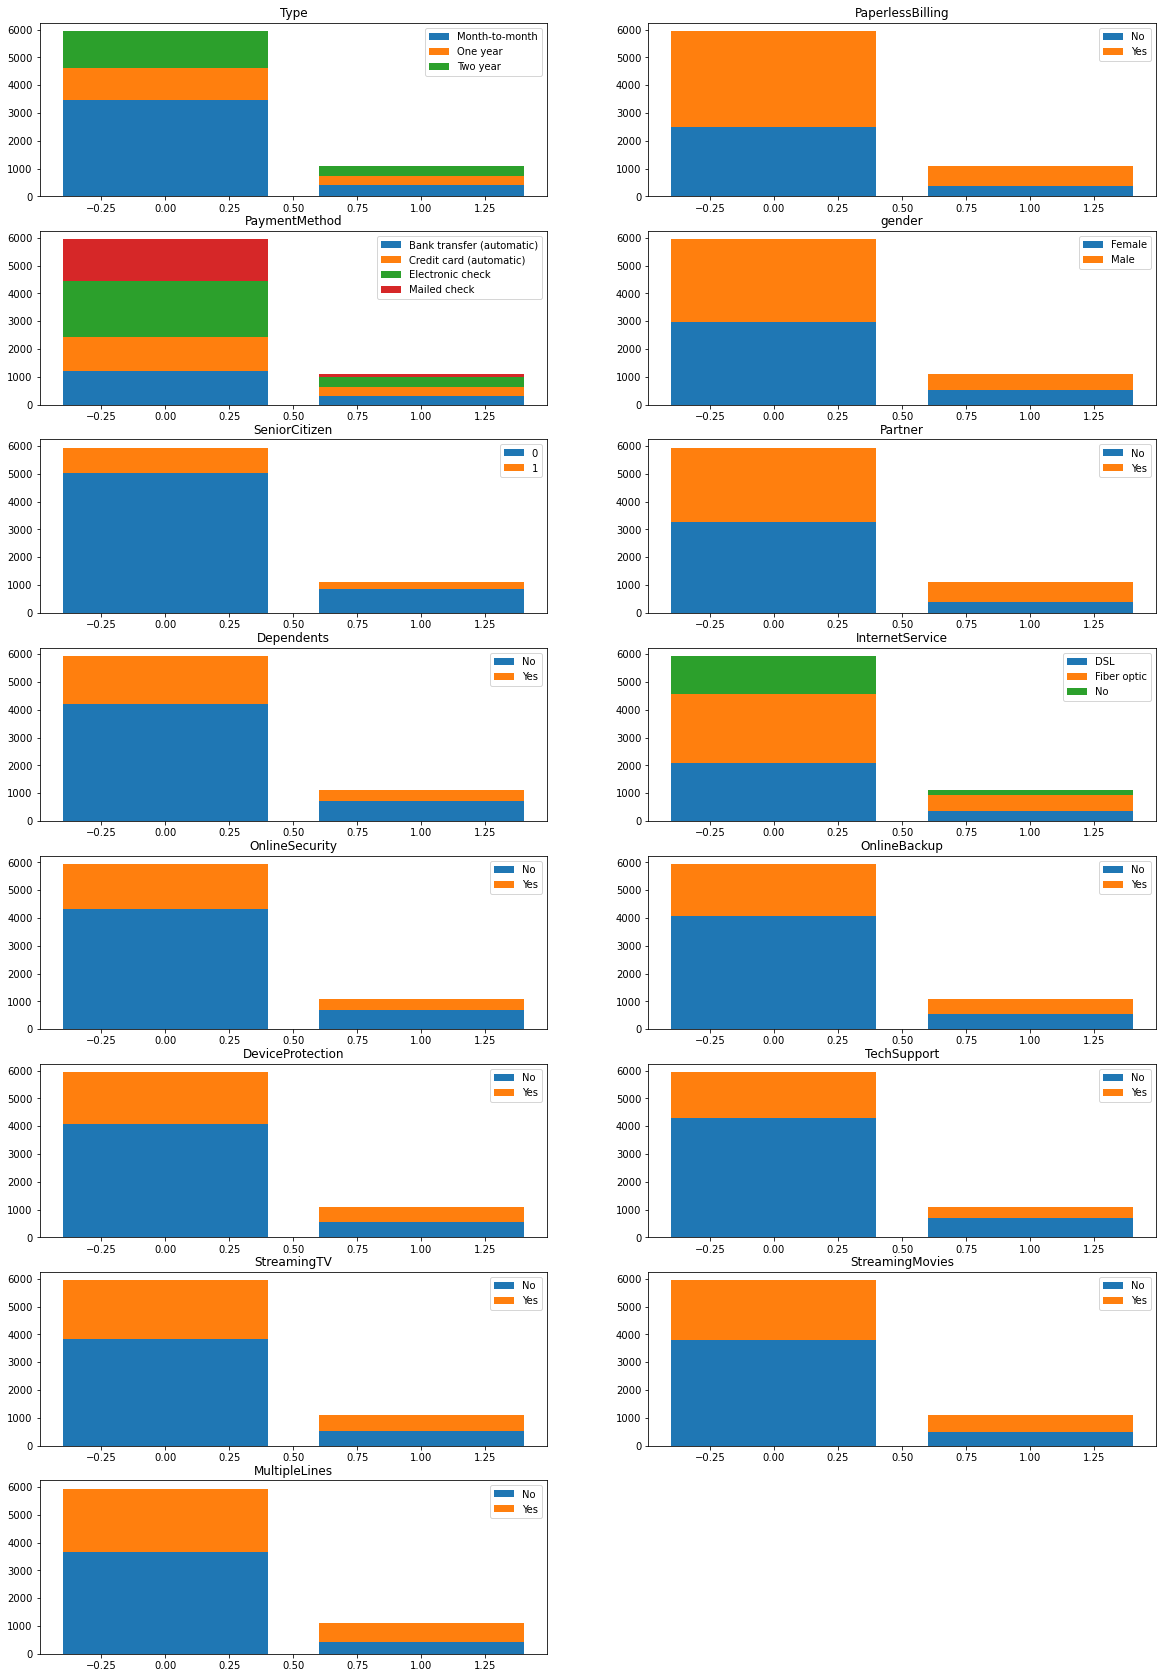

In [29]:
cols = 2
rows = int(np.ceil(len(categorial_columns) / cols))

plt.figure(figsize=(20, 30))

for idx, column in enumerate(categorial_columns):
    churn_grouped_df = churn_df.groupby([column, 'Churn'])['Churn'].count()
    churn_grouped_df = churn_grouped_df.unstack()

    ax = plt.subplot(rows, cols, idx + 1)

    ax.bar(churn_grouped_df.T.index,
           churn_grouped_df.T[churn_grouped_df.T.columns[0]], label=churn_grouped_df.T.columns[0])
    bottom = np.array(churn_grouped_df.T[churn_grouped_df.T.columns[0]])
    for color_idx, value in enumerate(churn_grouped_df.T.columns[1:]):
        ax.bar(churn_grouped_df.T.index,
               churn_grouped_df.T[value], bottom=bottom, label=value)
        bottom += np.array(churn_grouped_df.T[value])
    plt.title(column)
    plt.legend()

plt.show()

**Выводы:**

- Уйдет клиент или нет не зависит от типа его платежа - среди покинувших компанию нет ярко выраженного лидера по типу платежа. 

- Те, кому выставляют электронный чек уходят гораздо чаще.

- Меньше всего ушедших клиентов среди тех, кто платит почтовым чеком, а больше среди платящих электронными средствами. Основываясь на предыдущих выводах можно предположить, что с компанией остается консервативная(пожилая) аудитория, не столь продвинутая в знаниях современной техники, а молодые активные люди находят более выгодные предложения и переходят к конкурентам.

- Разницы в целевом показателе между мужчинами и женщинами нет.

- Меньше всего уходит тех, кто не пользуется интернетом у нашей компании, а владельцы оптоволокна и DSL предпочитают уйти гораздо чаще.

- Дополнительные услуги сильно не влияют на вероятность ухода клиента.

Изучим связь количественных признаков с таргетом:

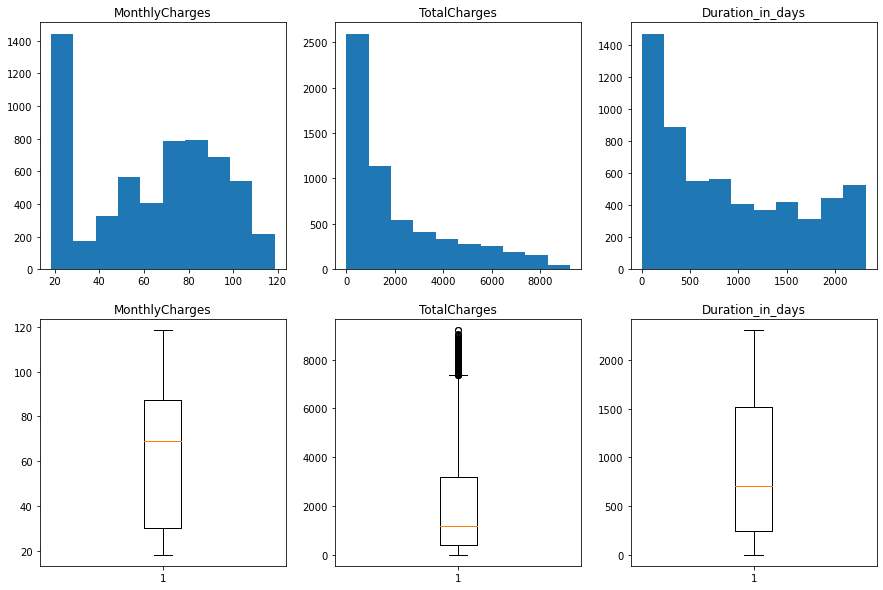

,MonthlyCharges,TotalCharges,Duration_in_days
count,5942.000000,5942.000000,5942.000000
mean,62.763455,2067.866420,893.681084
std,29.844462,2193.898483,716.958551
min,18.250000,0.000000,0.000000
25%,30.062500,374.352500,245.000000
50%,69.200000,1192.800000,702.000000
75%,87.237500,3173.837500,1523.000000
max,118.600000,9221.380000,2314.000000


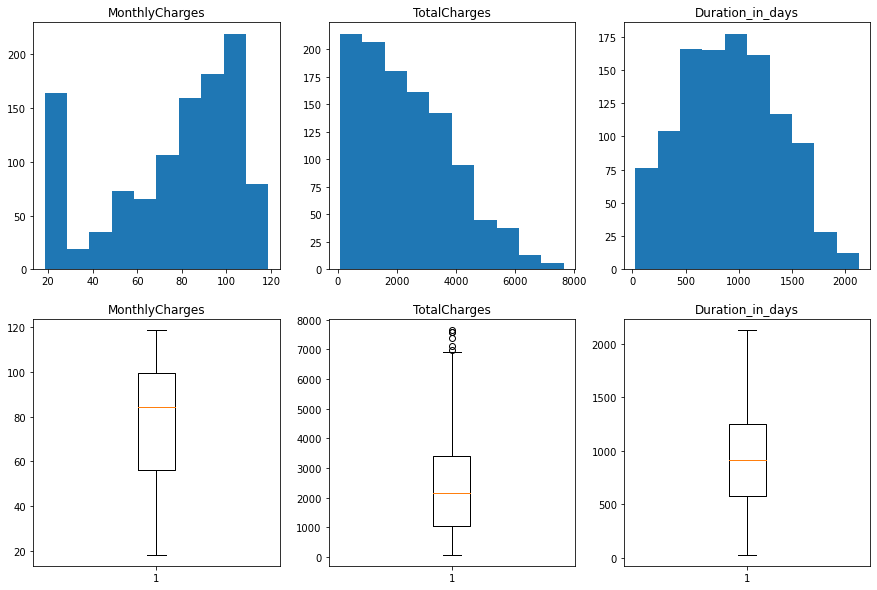

,MonthlyCharges,TotalCharges,Duration_in_days
count,1101.000000,1101.000000,1101.000000
mean,75.546004,2371.377275,924.863760
std,29.116213,1581.862275,458.771309
min,18.400000,77.840000,28.000000
25%,56.150000,1048.050000,577.000000
50%,84.200000,2139.030000,915.000000
75%,99.500000,3404.910000,1249.000000
max,118.750000,7649.760000,2129.000000


In [30]:
plot_numerical(churn_df[churn_df['Churn'] == 0])
plot_numerical(churn_df[churn_df['Churn'] == 1])

**Выводы:**

- Среди тех, кто ушел видно большое количество человек, с ежемесячным платежом 80+ долларов. Медианное значение ушедших(84) больше, чем оставшихся (69).

- Среди оставшихся много новых пользователей, а среди ушедших много тех, кто был с компанией от 500 до 1200 дней. Возможно компания привлекала новых пользователей, либо у нее появился новый дешевый тариф, а старые клиенты этим недовольны и ушли к конкурентам, где ниже цены.

- Возможно стоит подумать о скидке для лояльных клиентов, долгий срок пользующихся услугами компании.

Построим корелляционные матрицы для всех пар признаков:

In [31]:
churn_df.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Churn', 'Duration_in_days', 'SeniorCitizen']


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Duration_in_days,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
BeginDate,1.000000,0.548313,0.766249,0.081447,0.456389,0.421886,0.774207,0.450254,0.978521,0.011268,...,0.473514,0.208564,0.192197,0.403560,0.445583,0.456002,0.399506,0.359784,0.371863,0.428109
EndDate,0.548313,1.000000,0.285429,0.062936,0.169262,0.173493,0.217670,1.000000,0.396342,0.018274,...,0.177492,0.055518,0.117099,0.129611,0.203659,0.197691,0.112812,0.164794,0.177561,0.209337
Type,0.766249,0.285429,1.000000,0.106860,0.277462,0.388444,0.470860,0.094015,0.634155,0.000000,...,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498
PaperlessBilling,0.081447,0.062936,0.106860,1.000000,0.370495,0.467812,0.201703,0.083398,0.026799,0.000000,...,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972
PaymentMethod,0.456389,0.169262,0.277462,0.370495,1.000000,0.399526,0.335666,0.214832,0.350964,0.000000,...,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313
MonthlyCharges,0.421886,0.173493,0.388444,0.467812,0.399526,1.000000,0.710905,0.226280,0.387727,0.008175,...,0.203545,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.675883
TotalCharges,0.774207,0.217670,0.470860,0.201703,0.335666,0.710905,1.000000,0.302890,0.848337,0.000000,...,0.381958,0.084247,0.490081,0.522090,0.622445,0.640977,0.550065,0.641488,0.643210,0.573191
Churn,0.450254,1.000000,0.094015,0.083398,0.214832,0.226280,0.302890,1.000000,0.374569,0.008581,...,0.226688,0.046871,0.056621,0.132594,0.229482,0.218380,0.103652,0.200198,0.222232,0.261237
Duration_in_days,0.978521,0.396342,0.634155,0.026799,0.350964,0.387727,0.848337,0.374569,1.000000,0.000000,...,0.453688,0.198729,0.060845,0.395693,0.414982,0.426931,0.404795,0.339313,0.339313,0.398222
gender,0.011268,0.018274,0.000000,0.000000,0.000000,0.008175,0.000000,0.008581,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000


In [32]:
churn_df.global_phik()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Churn', 'Duration_in_days', 'SeniorCitizen']


(array([[1.        ],
        [1.        ],
        [1.        ],
        [0.32428829],
        [       nan],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [       nan],
        [0.36781421],
        [0.58350621],
        [1.        ],
        [1.        ],
        [0.42289489],
        [0.51917298],
        [0.69087832],
        [0.64576991],
        [0.61728881],
        [0.75403992],
        [       nan]]),
 array(['BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
        'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
        'Duration_in_days', 'gender', 'SeniorCitizen', 'Partner',
        'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport', 'StreamingTV',
        'StreamingMovies', 'MultipleLines'], dtype=object))

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Churn', 'Duration_in_days', 'SeniorCitizen']


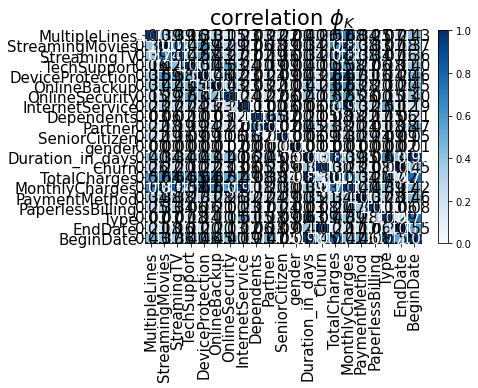

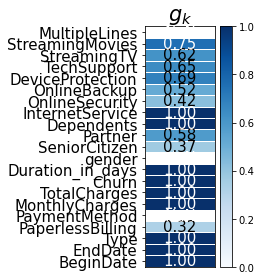

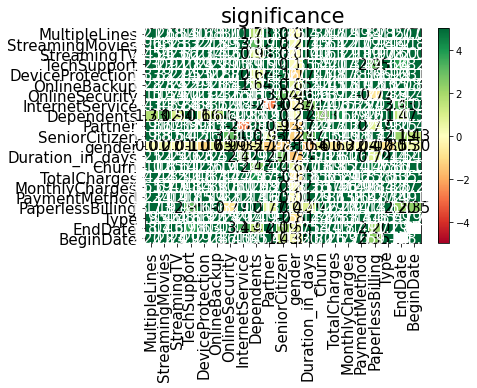

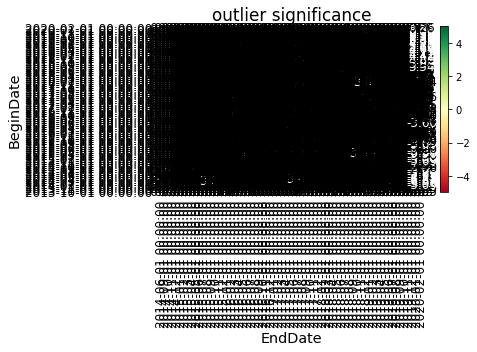

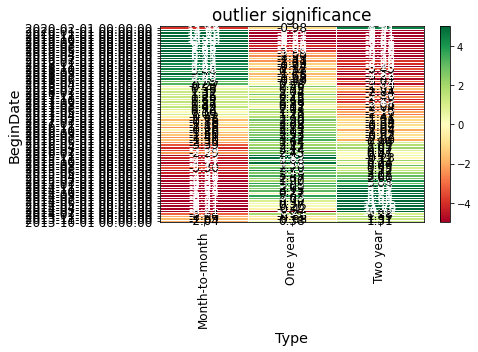

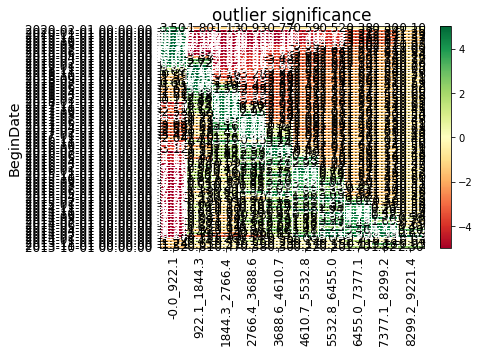

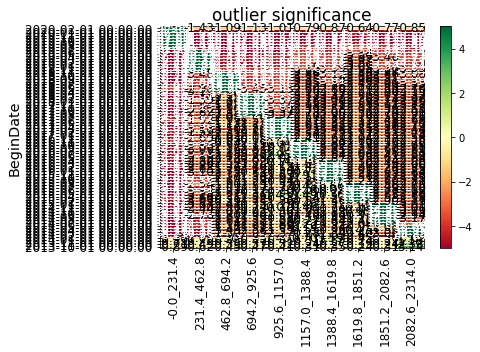

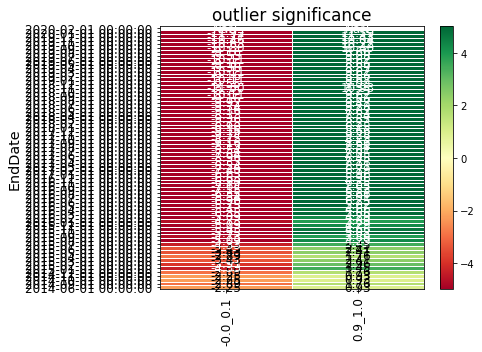

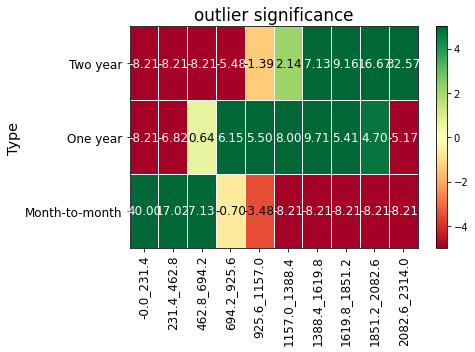

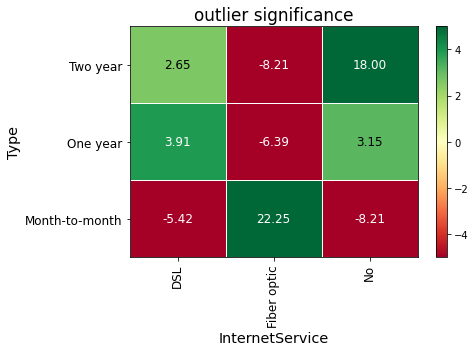

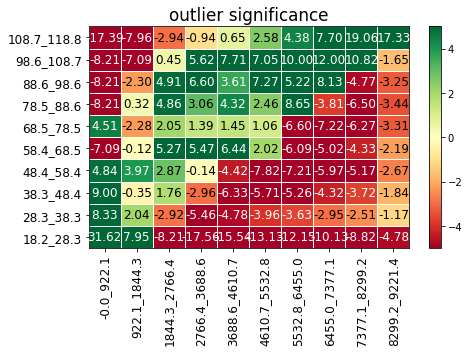

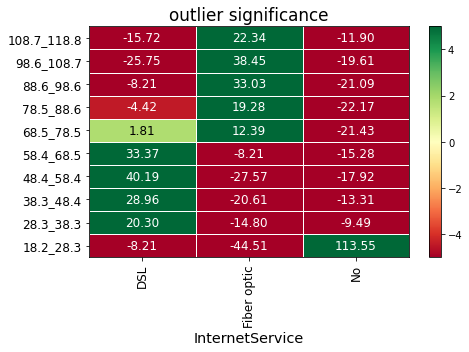

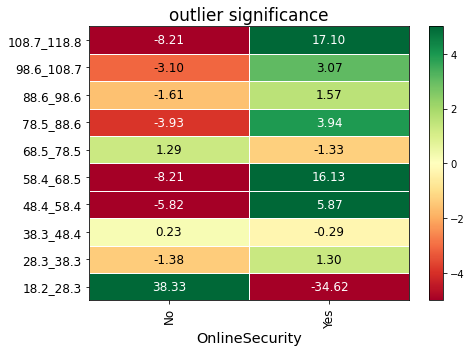

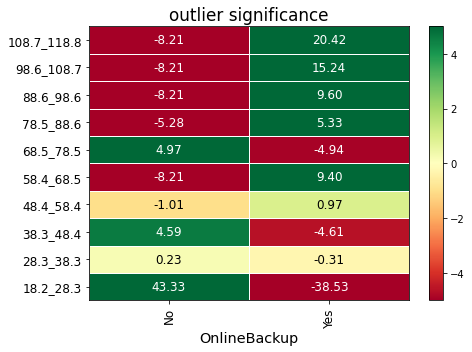

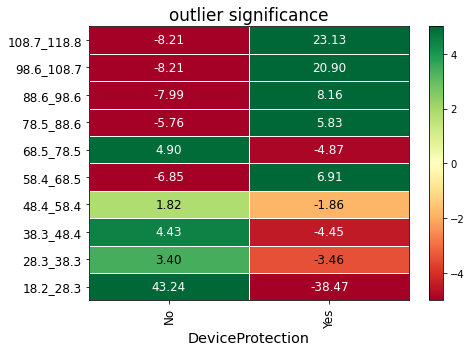

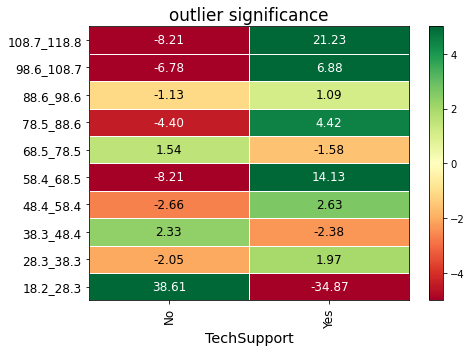

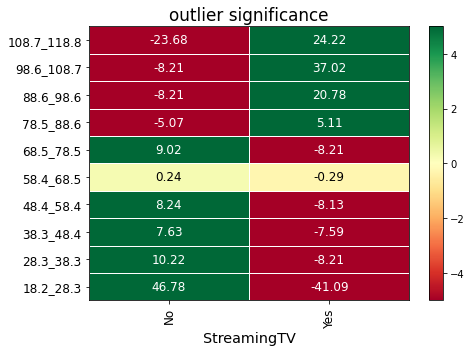

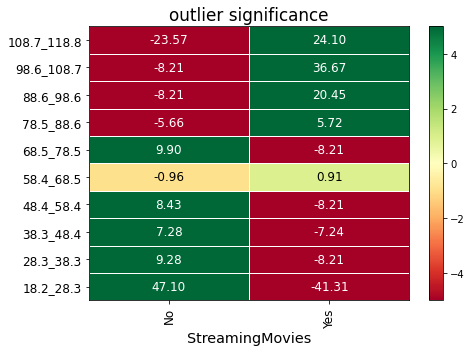

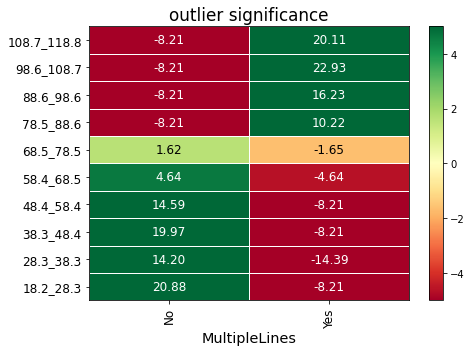

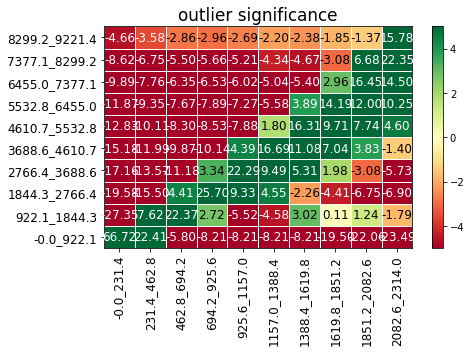

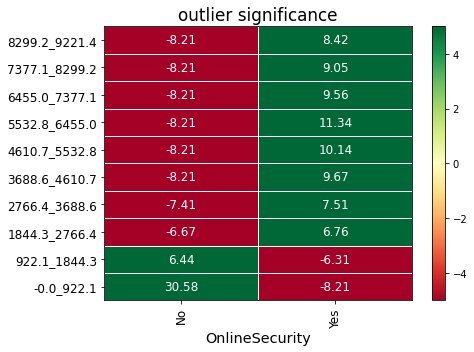

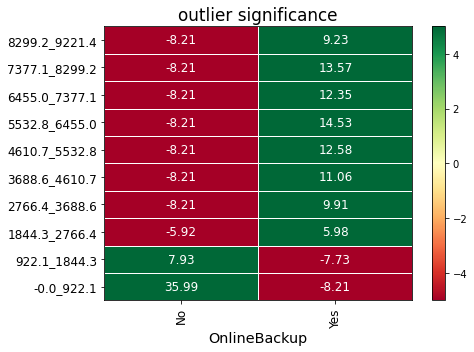

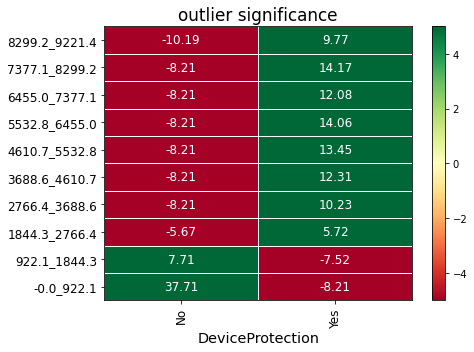

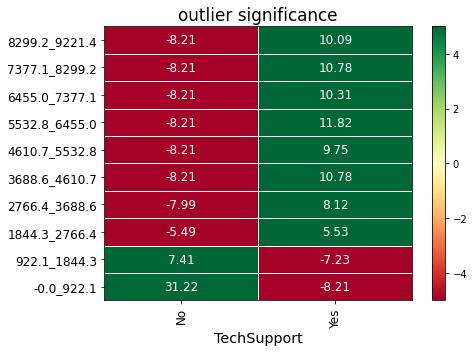

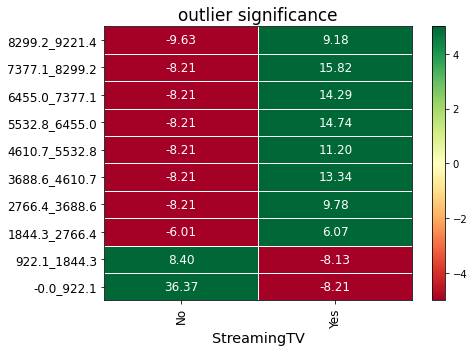

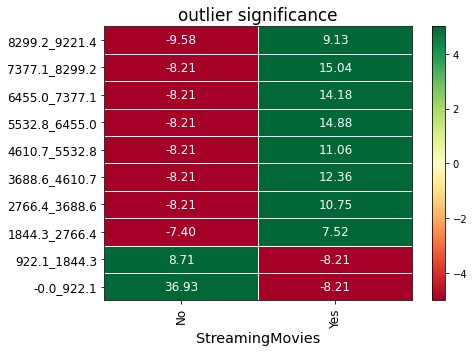

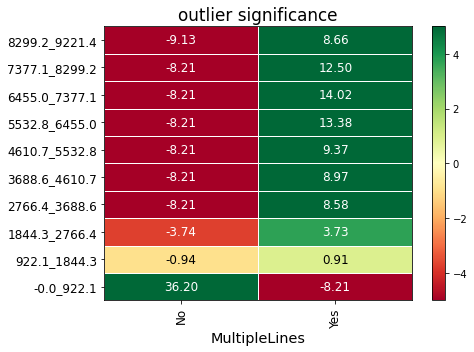

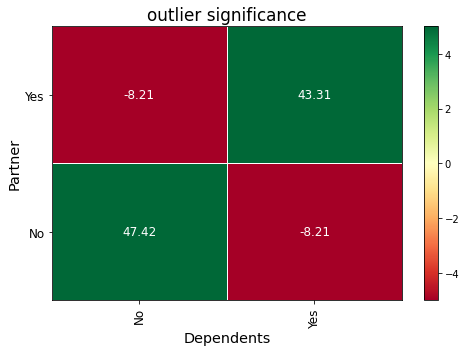

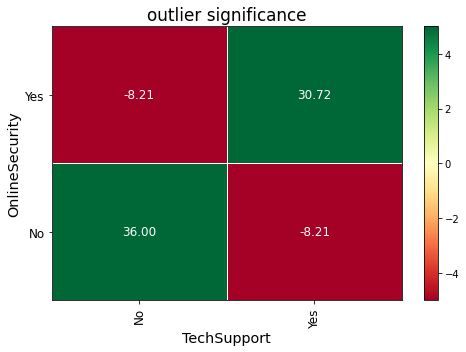

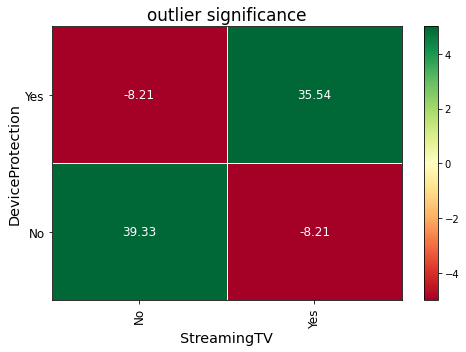

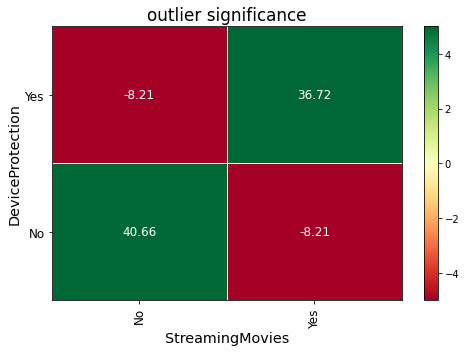

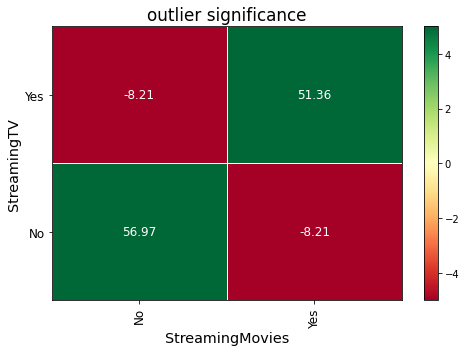

(                  BeginDate   EndDate      Type  PaperlessBilling  \
 BeginDate          1.000000  0.548313  0.766249          0.081447   
 EndDate            0.548313  1.000000  0.285429          0.062936   
 Type               0.766249  0.285429  1.000000          0.106860   
 PaperlessBilling   0.081447  0.062936  0.106860          1.000000   
 PaymentMethod      0.456389  0.169262  0.277462          0.370495   
 MonthlyCharges     0.421886  0.173493  0.388444          0.467812   
 TotalCharges       0.774207  0.217670  0.470860          0.201703   
 Churn              0.450254  1.000000  0.094015          0.083398   
 Duration_in_days   0.978521  0.396342  0.634155          0.026799   
 gender             0.011268  0.018274  0.000000          0.000000   
 SeniorCitizen      0.050862  0.090502  0.086231          0.242133   
 Partner            0.473514  0.177492  0.179736          0.013218   
 Dependents         0.208564  0.055518  0.147680          0.172593   
 InternetService    

In [33]:
report.correlation_report(churn_df, pdf_file_name='test.pdf')

**Выводы:**

- BeginDate имеет очень сильную зависимость с Duration_in_days, а EndDate буквально значит тоже самое, что и Churn - эти признаки(даты) надо удалить.

- Дополнительные услуги(стриминг, поддержка и т.д.) взаимосвязаны, теоретически их можно было бы объединить в один признак.


Посмотрим отдельно корелляцию между количественными данными:

In [34]:
churn_df[numeric_columns].corr()

,MonthlyCharges,TotalCharges,Duration_in_days
MonthlyCharges,1.000000,0.630440,0.220054
TotalCharges,0.630440,1.000000,0.821746
Duration_in_days,0.220054,0.821746,1.000000


**Вывод:**

- У нас есть сильная корелляция(0,82) между TotalCharges и Duration_in_days - проблема мультиколлинеарности в данных , что логично - чем дольше клиент платит, тем больше итоговая сумма. Можем удалить столбец Total_charges, чтобы оптимизировать обучение моделей.
- Также удалим столбцы InternetService, StreamingTV, StreamingMovies - они имеют сильную зависимость с MonthlyCharges.

In [35]:
del churn_df['TotalCharges']
numeric_columns = ['MonthlyCharges', 'Duration_in_days']

In [36]:
del churn_df['BeginDate'], churn_df['EndDate'], churn_df['InternetService'], churn_df['StreamingTV'], churn_df['StreamingMovies']

In [37]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   Churn             7043 non-null   float64
 5   Duration_in_days  7043 non-null   int64  
 6   gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   int64  
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  MultipleLines     7043 non-null   object 
dtypes: float64(2), int64(2), object(11)
memory usage: 880.4+ KB


### Портрет уходящего клиента


Клиент, который с большей вероятностью прекратит пользоваться услугами компании имеет следующие черты:

- Высокая абонентская плата в месяц(80+ долларов)

- Срок пользования услугами компании от 500 до 1000 дней

- Владелец оптоволоконного интернет-соединения

- Это активный человек, разбирающийся в современных технологиях, и предпочитающий использовать электронные чеки/способы оплаты



## Обучение моделей

Разобьем выборку на таргет и признаки:

In [38]:
target = churn_df['Churn'] 
features = churn_df.drop(columns=['Churn'])

Проведем разбиение выборки на трейн и тест в соотношении 3:1.

In [39]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=80523)

Закодируем признаки:

In [40]:
ce_ord = ce.OrdinalEncoder(cols = ['Type',
    'PaperlessBilling',
    'PaymentMethod',
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'MultipleLines'])
features_train = ce_ord.fit_transform(features_train, target_train)
features_test = ce_ord.transform(features_test, target_test)

В нашей работе будем использовать три классификатора: Случайный лес, LGBM и Catboost. Для подбора гиперпараметров воспользуемся гридсерчем.

Сначала посмотрим на Случайный лес:

In [41]:
rfc = RandomForestClassifier(class_weight='balanced',
                             bootstrap=True,
                             random_state=80523)

rfc_params = {
     'n_estimators': range(10, 201, 10),
     'max_depth': range(1,8),
     'criterion': ['gini', 'entropy'],
     'max_features': ['sqrt', 'log2']

}

grid_search_rfc = GridSearchCV(rfc,
                                   rfc_params, 
                                   verbose=3,
                                   cv=5,
                                   n_jobs=-1,
                                  scoring='roc_auc')


grid_search_rfc.fit(features_train, target_train)
grid_search_rfc.best_score_
grid_search_rfc.best_params_

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'sqrt',
 'n_estimators': 170}

In [42]:
rfc = RandomForestClassifier(class_weight='balanced',
                             bootstrap=True,
                             random_state=80523)

rfc_params = {
     'n_estimators': [170],
     'max_depth': [6],
     'criterion': ['entropy'],
     'max_features': ['sqrt']

}

grid_search_rfc = GridSearchCV(rfc,
                                   rfc_params, 
                                   verbose=3,
                                   cv=5,
                                   n_jobs=-1,
                                  scoring='roc_auc')


grid_search_rfc.fit(features_train, target_train)
grid_search_rfc.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


0.8279149441754654

**Вывод:**
Случайный лес не преодолевает необходимое по техническому заданию значение (ROC-AUC = 0,83 < 0,85)

Теперь обучим LGBM-классификатор. Для него используем пайплайн с функцией масштабирования данных.

In [43]:
pipe_lgbm = Pipeline(steps=[('scaler', StandardScaler()),
                            ('lgbm', LGBMClassifier(random_state=80523,
                                                    objective='binary',
                                                    class_weight='balanced',
                                                    silent=True))])

lgbm_params = {
 'lgbm__max_depth': [x for x in range(1,6)],
 'lgbm__n_estimators': [x for x in range(100,1100, 100)],
 'lgbm__learning_rate': [0.5, 0.6, 0.7]
}


grid_search_lgbm = GridSearchCV(pipe_lgbm,
                                lgbm_params, 
                                verbose=3,
                                cv=5,
                                n_jobs=-1,
                                scoring='roc_auc')



grid_search_lgbm.fit(features_train, target_train)
grid_search_lgbm.best_score_
grid_search_lgbm.best_params_

Fitting 5 folds for each of 150 candidates, totalling 750 fits


{'lgbm__learning_rate': 0.5, 'lgbm__max_depth': 2, 'lgbm__n_estimators': 600}

In [44]:
pipe_lgbm = Pipeline(steps=[('scaler', StandardScaler()),
                            ('lgbm', LGBMClassifier(random_state=80523,
                                                    objective='binary',
                                                    class_weight='balanced',
                                                    silent=True))])

lgbm_params = {
 'lgbm__max_depth': [2],
 'lgbm__n_estimators': [600],
 'lgbm__learning_rate': [0.5]
}


grid_search_lgbm = GridSearchCV(pipe_lgbm,
                                lgbm_params, 
                                verbose=3,
                                cv=5,
                                n_jobs=-1,
                                scoring='roc_auc')



grid_search_lgbm.fit(features_train, target_train)
grid_search_lgbm.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


0.914323792292571

**Вывод:**
Лучший LGBM-классификатор преодолевает необходимое по техническому заданию значение (ROC-AUC = 0,914 > 0,85).

Теперь взглянем, как с задачей справится КэтБуст:

In [45]:
catboost = CatBoostClassifier(loss_function='Logloss', random_seed=80523,silent=True)

catboost_params = {
 'depth': [x for x in range(1,3)],
 'iterations': [x for x in range(100,500, 100)],
 'learning_rate': [0.5, 0.6],
 'l2_leaf_reg':[x for x in range(1,2)],
}



grid_search_catboost = GridSearchCV(catboost,
                                   catboost_params, 
                                   verbose=3,
                                   cv=5,
                                   n_jobs=-1,
                                   scoring='roc_auc')


grid_search_catboost.fit(features_train, target_train)
grid_search_catboost.best_score_
grid_search_catboost.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


{'depth': 2, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.5}

In [46]:
catboost = CatBoostClassifier(loss_function='Logloss', random_seed=80523,silent=True)

catboost_params = {
 'depth': [2],
 'iterations': [400],
 'learning_rate': [0.5],
 'l2_leaf_reg':[1],
}



grid_search_catboost = GridSearchCV(catboost,
                                   catboost_params, 
                                   verbose=3,
                                   cv=5,
                                   n_jobs=-1,
                                   scoring='roc_auc')


grid_search_catboost.fit(features_train, target_train)
grid_search_catboost.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


0.9382645881158819

In [47]:
table = pd.DataFrame({'Model': ['RandomForestClassifier', 'LGBMClassifier', 'CatBoostClassifier'], 'ROC-AUC':[0.82791494401754654, 0.914323792292571, 0.9382645881158819]}).sort_values('ROC-AUC', ascending=False)
table

,Model,ROC-AUC
2,CatBoostClassifier,0.938265
1,LGBMClassifier,0.914324
0,RandomForestClassifier,0.827915


**Вывод:**

- Из наших моделей CatBoostClassifier справляется лучше всех и показывает значение метрики 0,938. Для дальнейшего тестирования выберем модель КэтБуста со следующими гиперпараметрами: {'depth': 2, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.5}.

- Количество данных у нас небольшое, а потому время обучения моделей маленькое. 

Посмотрим значимость признаков для модели Catboost:

In [48]:
importances_df = pd.DataFrame(grid_search_catboost.best_estimator_.feature_importances_, index = features_test.columns, columns=['importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)
importances_df.style.bar()

,importances
Duration_in_days,74.529348
MonthlyCharges,11.482698
Type,4.802204
PaymentMethod,2.206100
Partner,1.665851
MultipleLines,1.455401
DeviceProtection,1.046254
OnlineBackup,0.732081
Dependents,0.626717
TechSupport,0.399348


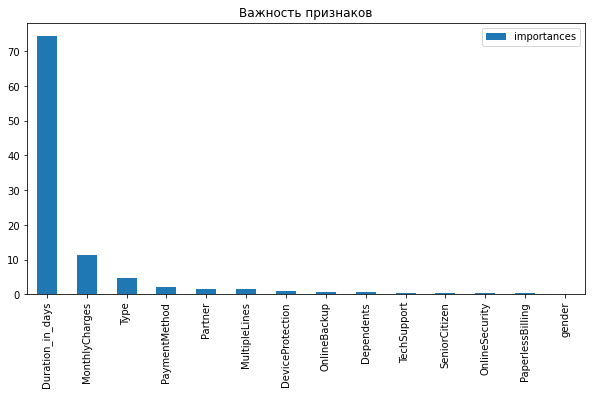

In [49]:
importances_df.plot(kind='bar', figsize=(10, 5), title='Важность признаков')
plt.show()

**Вывод:** 
- Самым важным признаком является Duration_in_days c огромным отрывом (74,5%), затем следуют MonthlyCharges(11,48%) и Type(4,8%).

- Гендер и дополнительные услуги по тарифу практически не имеют влияния на предсказание целевого признака.

## Тестирование модели

Получим предсказания(вероятности принадлежности к классам) нашей модели на тестовой выборке:

In [50]:
predict_proba = grid_search_catboost.predict_proba(features_test)[:, 1]

Устроим тест нашей модели, превысит ли метрика необходимое значение?

In [51]:
roc_auc_score(target_test, predict_proba)

0.9264058966132248

Результат чуть хуже, чем на трейне.

Построим ROC-кривую, чтобы наглядно проиллюстрировать качество нашей бинарной классификации.

In [52]:
def draw_ROC(target, predict_proba):
    fpr, tpr, thresholds = roc_curve(target, predict_proba, pos_label=1)
    plt.figure(figsize=(12, 10))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show() 

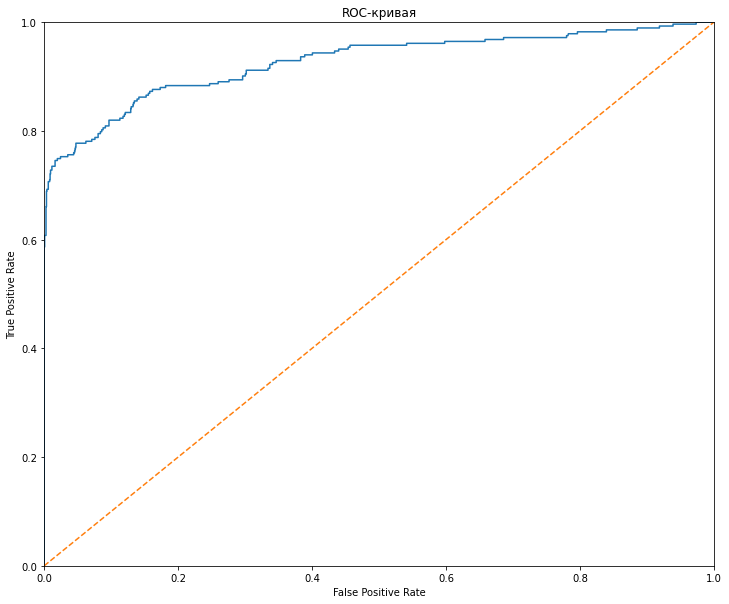

In [53]:
draw_ROC(target_test, predict_proba)

По графику видим, что наша модель предсказывает далеко не случайно, и площадь под кривой почти в два раза больше, чем под прямой линией.

In [54]:
predicted_test = grid_search_catboost.predict(features_test) 

Посмотрим точность предсказаний нашей модели, поскольку заказчику метрика ROC-AUC непонятна:

In [55]:
accuracy_score(target_test, predicted_test)

0.9483248154457694

Очень высокая точность у нашей модели!

Построим матрицу ошибок:

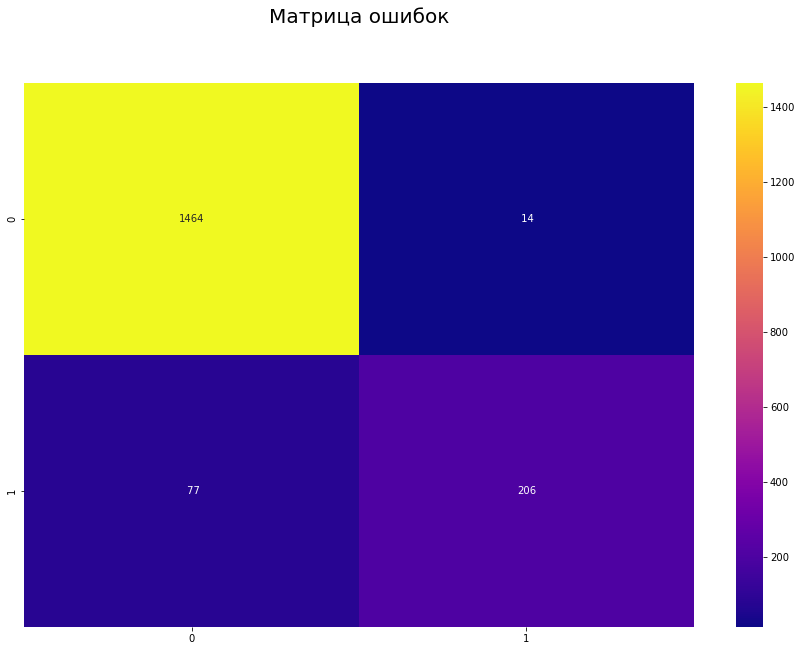

In [56]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(target_test, predicted_test),annot=True,fmt='3.0f',cmap="plasma")
plt.title('Матрица ошибок', y=1.1, size=20);

**Вывод:**
Хороший результат, модель очень мало ошибалась. Всего 14 ложно-положительных предсказаний и  77 ложно-отрицательных(в шесть раз больше). Наша модель лучше определяет уходящих, а не остающихся(это связано с дисбалансом классов и тем, как мы определили целевой признак).

Теперь посмотрим на константную Dummy модель и сравним ее предсказания с нашей моделью:

In [57]:
dummy_model = DummyClassifier(strategy='stratified')
dummy_model.fit(features_train,target_train)
dummy_pred_proba = dummy_model.predict_proba(features_test)[:, 1]
dummy_pred = dummy_model.predict(features_test)

In [58]:
roc_auc_score(target_test, dummy_pred_proba)

0.48369131239331153

In [59]:
accuracy_score(target_test, dummy_pred)

0.7314026121521863

**Вывод:** 

- Точность нашей модели на 20% превосходит точность константной модели, предсказания явно неслучайны.

- Советуем заказчику модель CatBoostClassifier со следующими гиперпараметрами: {'depth': 2, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.5}.

## Выводы


1) Полученные от заказчика данные были изучены, а затем была проведена их предобработка. Были добавлены два новых столбца - целевой признак Churn, который показывает статус клиента, и Duration_in_days, который обозначает время действия контракта.

2) Проведен исследовательский анализ данных, проанализированы количественные и категоральные признаки, проведена попытка найти связь между ними и целевым признаком. В результате удалось составить портрет "уходящего клиента".

3) На датасете обучены и протестированы несколько моделей машинного обучения. Лучшей из них стала модель CatBoostClassifier со следующими гиперпараметрами: {'depth': 2, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.5}, значение метрики ROC-AUC составило 0,926, а точность модели 0,948. Данная модель рекомендуется заказчику для решения его задачи.

## Отчет для заказчика

- **Какие пункты плана были выполнены, а какие — нет (поясните почему)?**

Были выполнены:

1) Предобработка данных: датасеты были изучены, дубликаты не обнаружены, пропуски устранены, форматы данных приведены в соответствие с содержанием. Все файлы объединены в один датасет. Были добавлены два новых столбца - целевой признак Churn, который показывает статус клиента, и Duration_in_days, который обозначает время действия контракта.

2) Исследовательский анализ: изучено распределение целевого признака и его зависимость от категориальных и количественных признаков. Была устранена проблема мультиколлинеарности в данных, удалены неинформативные и дублирующиеся признаки. На основе анализа был составлен следующий портрет "потенциально уходящего клиента":

- Высокая абонентская плата в месяц(80+ долларов)

- Срок пользования услугами компании от 500 до 1000 дней

- Владелец оптоволоконного интернет-соединения

- Это активный человек, разбирающийся в современных технологиях, и предпочитающий использовать электронные чеки/способы оплаты

3) Исследование моделей

• В работе были обучены и протестированы три типа классификаторов:  Случайный лес, LGBM и Catboost  с различными гиперпараметрами, которые были подобраны с помощью Gridsearch на основе кроссвалидации по метрике ROC-AUC.

In [60]:
table

,Model,ROC-AUC
2,CatBoostClassifier,0.938265
1,LGBMClassifier,0.914324
0,RandomForestClassifier,0.827915



4) Тестирование. Лучшая модель CatBoost показала на тестовой выборке значение метрики 0.9264, что превышает целевой показатель 0,85.

Для этой модели была исследована важность признаков:


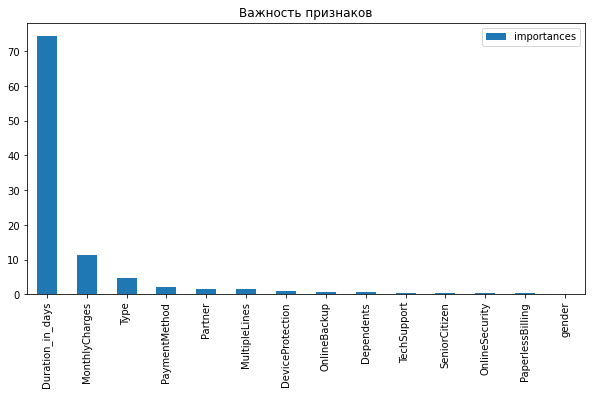

In [61]:
importances_df.plot(kind='bar', figsize=(10, 5), title='Важность признаков')
plt.show()

- Самым важным признаком для модели стал Duration_in_days (74,5%), затем следуют MonthlyCharges(11,48%) и Type(4,8%).

- Гендер и дополнительные услуги по тарифу практически не имели влияния на предсказание целевого признака

5) Иллюстрация нашей модели для заказчика:

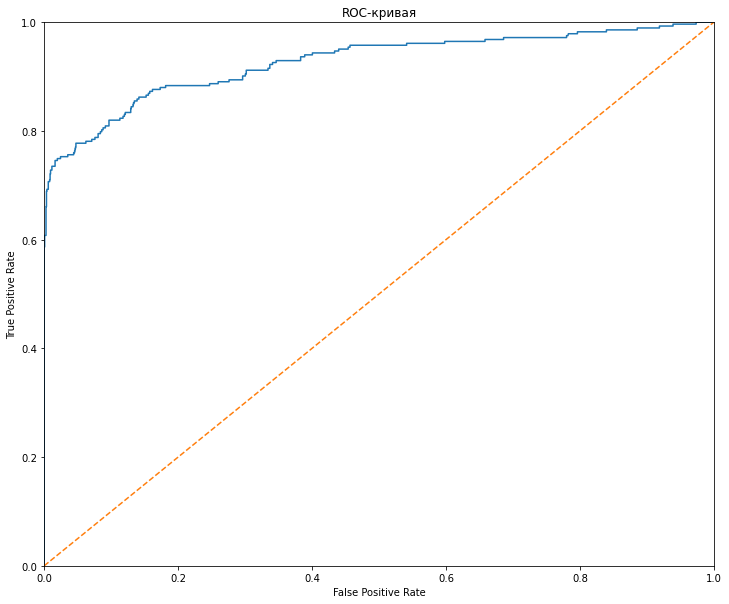

In [62]:
draw_ROC(target_test, predict_proba)

**Пояснение:** ROC-кривая отражает связь между вероятностью ложной тревоги (доли ложно-положительных классификаций) и вероятностью «правильного обнаружения» (доли истинно-положительных классификаций). С ростом чувствительности растёт надёжность распознавания положительных наблюдений (снижается вероятность «пропуска цели»), но при этом растёт вероятность ложной тревоги.

В целом, кривая для нашей модели имеет параболическую форму. При этом, чем выше кривизна и кривая ближе к идеальной, тем лучше работает модель, а чем хуже, тем ближе к диагональной прямой линии, которая соответствует «бесполезному» классификатору, предсказывающему классы случайным образом.

Как видим, наша кривая гораздо ближе к идеальной, чем к "бесполезному" классификатору.

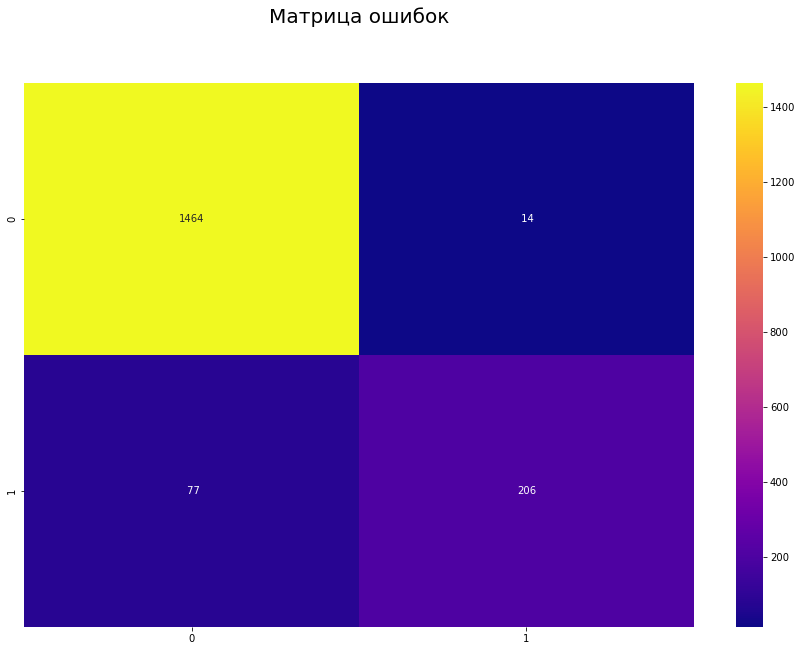

In [63]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(target_test, predicted_test),annot=True,fmt='3.0f',cmap="plasma")
plt.title('Матрица ошибок', y=1.1, size=20);

**Пояснение:** Наша модель показала хороший результат, она очень мало ошибалась. Всего 14 ложно-положительных предсказаний и  77 ложно-отрицательных. Наша модель лучше определяет уходящих, а не остающихся клиентов(это связано с дисбалансом классов и тем, как мы определили целевой признак).

- **Какие трудности возникли и как вы их преодолели?**

В данных присутствовала проблема мультиколлинеарности, решением стало удаление лишних признаков. Также столбцы 'BeginDate' и 'EndDate' могли привести к утечке данных и переобучению модели, а потому были заменены признаком 'Duration_in_days', обозначающим число дней, которые действовал/действует контракт клиента. Столбцы с датами были удалены.

- **Какие ключевые шаги в решении задачи вы выделили?**

1) предобратка данных и исправление ошибок

2) создание дополнительных признаков (выделение целевого признака и создание удобного признака для длительности контракта клиента)

3) анализ влияния признаков на целевой признак и создание портрета уходящего клиента. 

4) обучение разных моделей на данных и выбор лучшей из них.

5) тестирование лучшей модели и определение важности признаков для нее, а также иллюстрация работы модели для заказчика.


- **Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?**


- количественные: ['MonthlyCharges', 'Duration_in_days'],


- категориальные: ['Type','PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'MultipleLines'], 


- целевой признак - ['Churn']

RandomState всех операций проекта '80523'.

Признаки были закодированы с помощью порядкового кодировщика.

У моделей LGBM и CatBoost использовались встроенные кодировщики.

- **Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?**

Итоговая модель у нас СatBoostClassifier(loss_function='Logloss', random_seed=80523,silent=True) с параметрами:

- depth = 2


- iterations = 400


- learning_rate = 0.5


- l2_leaf_reg = 1


Итоговые метрики качества на тестовой выборке составили:


- ROC-AUC = 0.9264


- Точность нашей модели = 0.9483

